In [1]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import functools
from segment_anything.utils.onnx import SamOnnxModel
from segment_anything.modeling import Sam
import nibabel as nib
from skimage import io, transform
import torch
import torch.nn.functional as F

In [2]:
device = 'cuda'
# 1. Load the image
img = nib.load(r"E:\Mine\SAM_editor\static\nifti_files\img_CT_new.nii.gz")
img = np.asanyarray(img.dataobj)
min,max = img.min(),img.max()
img = np.repeat(img[...,481,None], 3, axis=-1)
img_1024 = transform.resize(
    img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
)


In [3]:
img_1024 = (img_1024 - min) / (max - min)
img_1024_tensor = (torch.tensor(img_1024).float().permute(2, 1, 0).unsqueeze(0).to(device))
img_1024_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [4]:
# 2. Load the Segment anything model
medsam_model = sam_model_registry["vit_b"]( checkpoint = r"E:\Mine\SAM_editor\SAM_testing_only\SAM_models\MedSAM\medsam_vit_b.pth").to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
medsam_model.device

device(type='cuda', index=0)

In [6]:
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

FOR BOX

In [24]:
box_np = np.array([[80,160,430,400]])
# transfer box_np t0 1024x1024 scale
W,H,_ = img.shape
box_1024 = box_np / np.array([[W, H, W, H]]) * 1024

In [25]:
box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=image_embedding.device)
len(box_torch.shape),box_torch.shape

(2, torch.Size([1, 4]))

In [26]:
box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=image_embedding.device)
if len(box_torch.shape) == 2:
    box_torch = box_torch[:, None, :]  # (B, 1, 4)

sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
    points=None,
    boxes=box_torch,
    masks=None,
    )
low_res_logits, _ = medsam_model.mask_decoder(
    image_embeddings=image_embedding,  # (B, 256, 64, 64)
    image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
    multimask_output=False,
    )

low_res_pred = torch.sigmoid(low_res_logits).detach()  # (1, 1, 256, 256)

low_res_pred = F.interpolate(
    low_res_pred,
    size=(H, W),
    mode="bilinear",
    align_corners=False,
    )  # (1, 1, gt.shape)
low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
medsam_seg = (low_res_pred > 0.5).astype(np.uint8)

In [27]:
# medsam_seg_resize = transform.resize(medsam_seg, (512, 512), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)
medsam_seg.shape

(512, 512)

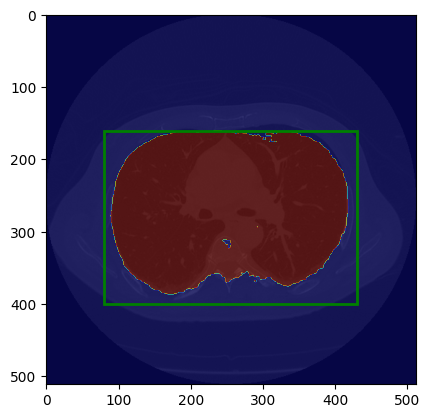

In [28]:
fig, ax = plt.subplots()
ax.imshow(np.transpose((img - min) / (max - min),(1,0,2)), cmap='gray')
ax.imshow(medsam_seg, cmap='jet', alpha=0.5)  # 'jet' colormap and 50% transparency
# ax.scatter( input_point[0,0], input_point[0,1], color='red', s=100, marker='x')
# ax.scatter( input_point[1,0], input_point[1,1], color='red', s=100, marker='x')

# Show the plot
# plt.axis('off')  # Hide axis
x0,y0,x1,y1 = box_np[0,0], box_np[0,1], box_np[0,2], box_np[0,3]
w = x1 - x0
h = y1 - y0
ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
plt.show()

FOR POINTS

In [ ]:
# 5. Prepare the prompt
input_point = np.array([[250,230], [441, 175]])
input_label = np.array([0,0])

# 6. Decode masks
masks = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)

In [ ]:
input_point.shape

In [ ]:
help(predictor.predict)

In [ ]:
masks[0].shape,masks[1],masks[2].shape

In [ ]:
plt.imshow(img_1024, cmap='gray')
plt.imshow(masks[0][2], cmap='jet', alpha=0.5)  # 'jet' colormap and 50% transparency
plt.scatter( input_point[0,0], input_point[0,1], color='red', s=100, marker='x')
plt.scatter( input_point[1,0], input_point[1,1], color='red', s=100, marker='x')

# Show the plot
# plt.axis('off')  # Hide axis
plt.show()

In [ ]:
output_mask = mask_generator.generate(img)
output_mask

In [ ]:
output_mask[0]

In [ ]:
sorted_output_mask = sorted(output_mask,key = lambda x: x['predicted_iou'])
for i in sorted_output_mask:
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.imshow(i['segmentation'], cmap='jet', alpha=0.5)  # 'jet' colormap and 50% transparency
    ax.scatter( int(i['point_coords'][0][0]), int(i['point_coords'][0][1]), color='red', s=100, marker='x')
    x, y, width, height = i['bbox']
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


    # Show the plot
    # plt.axis('off')  # Hide axis
    plt.show()
    print("predicted_iou : ",i['predicted_iou'])
    print("stability_score : ",i['stability_score'])

In [ ]:
output_mask[0]['segmentation'].astype(np.uint8).max()

In [ ]:
sorted_output_mask = sorted(output_mask,key = lambda x: x['predicted_iou'])
combinedmask = functools.reduce(lambda a, b: a + ( b['segmentation'].astype(np.uint8) * ( a.max() + 1)), output_mask, np.zeros_like(output_mask[0]['segmentation'], dtype=np.uint8))
print("np.unique(combinedmask)", np.unique(combinedmask), np.unique(combinedmask).shape)
fig, ax = plt.subplots()
# ax.imshow(img, cmap='gray')
ax.imshow(combinedmask, cmap='jet')  # 'jet' colormap and 50% transparency
# ax.scatter( int(i['point_coords'][0][0]), int(i['point_coords'][0][1]), color='red', s=100, marker='x')
# x, y, width, height = i['bbox']
# rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)


# Show the plot
# plt.axis('off')  # Hide axis
plt.show()
# print("predicted_iou : ",i['predicted_iou'])
# print("stability_score : ",i['stability_score'])

In [ ]:
output_mask[0]['segmentation'].astype(np.uint8)

In [ ]:
np.array([1]) & np.array([1000])